In [1]:
import pandas as pd
import numpy as np

from scipy import stats, special
from scipy.optimize import minimize 
import pingouin as pg


import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
age = pd.read_csv('../demo.csv')

In [3]:
db_mon = pd.read_csv('data/mon.csv')
db_med = pd.read_csv('data/med.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), 'participants medical: ', len(db_med['sub'].unique()))

Participants monetary:  95 participants medical:  95


In [4]:
# make a list with subjects number
s_am = list(age['sub'].unique())
s_ra = list(db_mon['sub'].unique())

# find participant in one list but not in the second
demo_no_ra = list(set(s_am)- set(s_ra))
ra_no_demo = list(set(set(s_ra)- set(s_am)))

print ('pariticpant with R&A and no MoCA:', ra_no_demo)
print ('pariticpant with MoCA and no R&A:', demo_no_ra)

age = age[age['sub'].isin(db_mon['sub'].values)]

# remove participants without age/moca from the db and add age, moca and gender
db_mon = db_mon.merge(age, left_on='sub', right_on='sub')
db_med = db_med.merge(age, left_on='sub', right_on='sub')

db_mon = db_mon[db_mon['moca_score']>25]
db_med = db_med[db_med['moca_score']>25]


print('Number of participants with all data:', len(db_med['sub'].unique()))

pariticpant with R&A and no MoCA: [64, 65, 67, 70, 12, 79, 81, 84, 21, 22, 89, 91, 31, 97, 34, 35, 98, 99, 45, 110, 47, 48, 111, 112, 53, 54, 62]
pariticpant with MoCA and no R&A: []
Number of participants with all data: 68


In [5]:
risk_min = 2 # the minimum number of trials participant chose the lottery.

# collect number of lottery selection by subject
choices_mon = db_mon[['sub','choice']].groupby(['sub']).sum()
choices_med = db_med[['sub','choice']].groupby(['sub']).sum()

# get the subject number for participant who were too risk averse
too_risk_averse_mon = list(choices_mon[choices_mon['choice']<risk_min].index)
too_risk_averse_med = list(choices_med[choices_med['choice']<risk_min].index)

print('Monetary too risk averse (', risk_min, '): ', too_risk_averse_mon)
print('Medical too risk averse (', risk_min, '): ', too_risk_averse_med)


# remove too risk averse particiants from the files
db_mon = db_mon[~db_mon['sub'].isin(too_risk_averse_mon)]
db_med = db_med[~db_med['sub'].isin(too_risk_averse_med)]

# compare monetary and medical lists and keep only valid participants in both
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

print('Final sample of participants with R&A data: ', len(db_med['sub'].unique()))

Monetary too risk averse ( 2 ):  [11, 40]
Medical too risk averse ( 2 ):  []
Final sample of participants with R&A data:  66


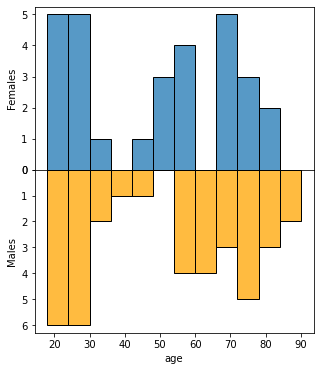

In [6]:
participants = db_med.drop_duplicates(['sub'])
fig, ax = plt.subplots(2, 1, figsize=(5, 6),sharex=True)

sns.histplot(participants[participants['gender']=='F']['age'], binwidth=6, ax=ax[0])
sns.histplot(participants[participants['gender']=='M']['age'], binwidth=6, color='orange', ax=ax[1])

ax[0].set(ylabel='Females', xlabel='')
ax[1].set(ylabel='Males')
ax[1].invert_yaxis()

plt.subplots_adjust(wspace=0, hspace=0)

In [7]:
# remove missing trials
db_mon = db_mon.dropna()
db_mon['choice'] = db_mon['choice'].astype('int')

# get final number of subject and trials
n_subs = db_mon['sub'].unique().shape[0]
print("Final sample includ {} subjects".format(n_subs))

Final sample includ 66 subjects


In [8]:
# remove missing trials
db_med = db_med.dropna()
db_med['choice'] = db_med['choice'].astype('int')

# get final number of subject and trials
n_subs_med = db_med['sub'].unique().shape[0]
print("Final sample includ {} subjects".format(n_subs_med))

Final sample includ 66 subjects


In [9]:
#db_mon=db_mon[db_mon.value>5]
#db_med=db_med[db_med.value>5]

In [10]:
db_med = db_med[db_med.catch < 7]

# add serial number for participants
db_med['subn'] = db_med['sub'].rank(method='dense').astype(int)-1

# sort dataframe based on subject, makes it easier to compare the output of the models.
db_med = db_med.sort_values('sub').reset_index(drop=True)

n_subs_med = db_med['subn'].unique().shape[0]
sub_idx_med = db_med.subn.tolist()
sub_idx_med = db_med.subn.tolist()

print("Final sample includ {} subjects and {} valid trials".format(n_subs_med, len(sub_idx_med)))

Final sample includ 66 subjects and 5502 valid trials


In [11]:
db_med['level']= np.where(db_med["value"] == 5, 1,
                          np.where(db_med["value"] == 8, 2,
                                   np.where(db_med["value"] == 12, 3, 4)))

In [12]:
db_med['l1'] = db_med.level > 0
db_med['l2'] = db_med.level > 1
db_med['l3'] = db_med.level > 2
db_med['l4'] = db_med.level > 3

db_med['l1'] = db_med['l1'].astype(int)
db_med['l2'] = db_med['l2'].astype(int)
db_med['l3'] = db_med['l3'].astype(int)
db_med['l4'] = db_med['l4'].astype(int)

In [13]:
db_mon = db_mon[db_mon.catch < 7]

# add serial number for participants
db_mon['subn'] = db_mon['sub'].rank(method='dense').astype(int)-1

# sort dataframe based on subject, makes it easier to compare the output of the models.
db_mon = db_mon.sort_values('sub').reset_index(drop=True)

n_subs = db_mon['subn'].unique().shape[0]
sub_idx = db_mon.subn.tolist()
sub_idx = db_mon.subn.tolist()

print("Final sample includ {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

Final sample includ 64 subjects and 5350 valid trials


In [14]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    
    # caclulate proportion between SVs
    svLotto = (db_sub['value'].values ** α) * (1-(db_sub['risk'].values+(β * (db_sub['ambiguity'].values/2))))
    svRef = 5 ** α
    p = special.expit((svRef - svLotto) * γ) 
    
    # Calculate the negative log-likelihood for normal distribution
    neg_LL = -np.sum(stats.norm.logpdf(db_sub.choice, p))
    return neg_LL

def MLE_analysis():
    mle_model = minimize(MLE_riskamb, np.array([0.5,0.5,1]), method='L-BFGS-B', bounds=[(0,2),(-1.5,1.5),(-np.inf,np.inf)])
    x = mle_model.x
    return x

In [15]:
subs = db_mon['sub'].unique()
mLL = pd.DataFrame()

for sub in subs:
    db_sub = db_mon[db_mon['sub']==sub]
    x = MLE_analysis()
    temp = pd.DataFrame({'sub': sub, 'alpha_mll' : x[0], 'beta_mll': x[1], 'gamma_mll': x[2]},index=[0])
    mLL = pd.concat([mLL, temp], axis=0, join='outer')
mLL.head()

,sub,alpha_mll,beta_mll,gamma_mll
0,10,1.045660,0.702967,-0.913224
0,13,0.000000,-1.500000,1.635945
0,14,0.000000,1.316600,-25.048151
0,15,0.480626,-1.500000,0.618760
0,16,2.000000,-1.500000,0.057570


In [16]:
with pm.Model() as RiskAmb_free:

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)

    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    
      
    # Expected value of outcome
    svLotto = db_mon['value'].values * (db_mon['risk'].values - (db_mon['ambiguity'].values/2))
    svRef = 5
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])
    
    mon_free = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, gSig, gMu]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 89 seconds.


In [17]:
with pm.Model() as RiskAmb_normal:
    # Hyper Priors
    aMu = pm.Normal('aMu', 0.7 ,1)
    aSig = pm.Exponential('aSig', 1)
    bMu = pm.Normal('bMu', 0.3,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)


    α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    
    
      
    # Expected value of outcome
    svLotto = (db_mon['value'].values ** α[sub_idx]) * (db_mon['risk'].values - (β[sub_idx] * (db_mon['ambiguity'].values/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])

    mon_normal = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, α, gSig, gMu, bSig, bMu, aSig, aMu]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 899 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [18]:
with pm.Model() as RiskAmb_beta:
    # Hyper Priors
    alpha_a = pm.TruncatedNormal('alpha_a', 2, 1, lower = 0.3)
    alpha_b = pm.TruncatedNormal('alpha_b', 2, 1, lower = 0.3)
    
    bMu = pm.Normal('bMu', 0.3,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
    
    alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
      
    # Expected value of outcome
    svLotto = (db_mon['value'].values ** α[sub_idx]) * (db_mon['risk'].values - (β[sub_idx] * (db_mon['ambiguity'].values/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_mon['choice'])

    mon_beta = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, alpha, gSig, gMu, bSig, bMu, alpha_b, alpha_a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1029 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [19]:
az.compare({'Model free': mon_free, 'Nomral': mon_normal, 'Beta': mon_beta})

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/reve

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Beta,0,-1782.238836,180.625786,0.000000,0.968434,44.859119,0.000000,True,log
Nomral,1,-1783.694800,176.954010,1.455964,0.000000,44.768884,2.168094,True,log
Model free,2,-2543.033603,57.521148,760.794767,0.031566,37.574579,37.341928,True,log


/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


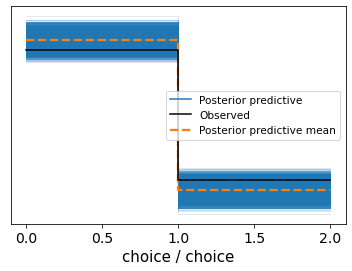

In [20]:
with RiskAmb_beta:
    ppc = pm.sample_posterior_predictive(
        mon_beta)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb_beta));

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

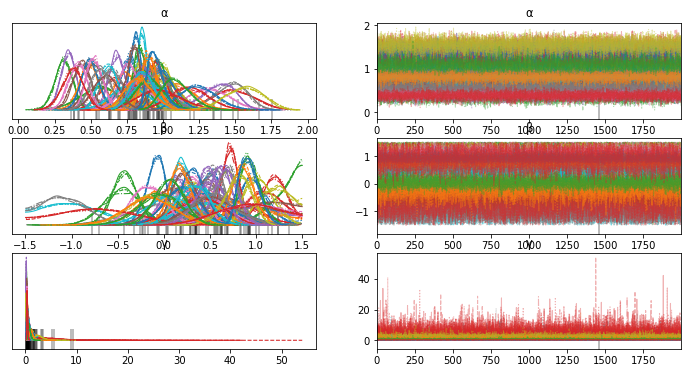

In [21]:
az.plot_trace(mon_beta, var_names=['α','β','γ'])

# Medical

In [22]:
with pm.Model() as RiskAmb_simple:
    
    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
   
    
    alpha = pm.Beta('alpha', 2,4, shape = n_subs_med)#alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', 0.3, 1, lower = -1.5, upper = 1.5, shape = n_subs_med)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs_med)
      
    # Expected value of outcome
    val = db_med['value'].values * α[sub_idx_med]
    svLotto = val * (db_med['risk'].values - (β[sub_idx_med] * (db_med['ambiguity'].values/2)))
    svRef = α[sub_idx_med]
    p = (svLotto - svRef)/γ[sub_idx_med]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_med['choice'])
    
    med_simple = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, alpha, gSig, gMu]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 998 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with pm.Model() as RiskAmb_equ:
    # hyper parameters
    sMu = pm.TruncatedNormal('sMu', 1, 1, lower = 0)
    sSig = pm.Exponential('sSig', 1)
    
    lMu = pm.TruncatedNormal('lMu', 1, 1, lower = 0)
    lSig = pm.Exponential('lSig', 1)  
    
    iMu = pm.TruncatedNormal('iMu', 1, 1, lower = 0)
    iSig = pm.Exponential('iSig', 1) 
                             
    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
   
    med_slope = pm.Gamma('med_slope', sMu, sSig, shape = n_subs_med)
    med_linslope = pm.TruncatedNormal('med_linslope', lMu, lSig, lower = 0, shape = n_subs_med)
    med_intercept = pm.TruncatedNormal('med_intercept', iMu, iSig, lower = 0, shape = n_subs_med)
    
    alpha = pm.Beta('alpha', 2,4, shape = n_subs_med)#alpha_a, alpha_b, shape = n_subs)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', 0.3, 1, lower = -1.5, upper = 1.5, shape = n_subs_med)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs_med)
      
    # Expected value of outcome
    val = (med_intercept[sub_idx_med] + med_linslope[sub_idx_med] * db_med['value'].values ** med_slope[sub_idx_med]) ** α[sub_idx_med]
    svLotto = val * (db_med['risk'].values - (β[sub_idx_med] * (db_med['ambiguity'].values/2)))
    svRef = (med_intercept[sub_idx_med] + med_linslope[sub_idx_med]) ** α[sub_idx_med]
    p = (svLotto - svRef)/γ[sub_idx_med]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_med['choice'])

    med_equ = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, alpha, med_intercept, med_linslope, med_slope, gSig, gMu, iSig, iMu, lSig, lMu, sSig, sMu]


In [ ]:
with pm.Model() as RiskAmb_unique:
    
    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)
   
    level1 = pm.TruncatedNormal('level1', 1, 1, lower = 0, shape = n_subs_med )
    level2 = pm.TruncatedNormal('level2', 1, 1, lower = 0, shape = n_subs_med )
    level3 = pm.TruncatedNormal('level3', 1, 1, lower = 0, shape = n_subs_med )
    level4 = pm.TruncatedNormal('level4', 1, 1, lower = 0, shape = n_subs_med )
    
    alpha = pm.Beta('alpha', 2,4, shape = n_subs_med)
    α = pm.Deterministic('α', alpha * 2)
    β = pm.TruncatedNormal('β', 0.3, 1, lower = -1.5, upper = 1.5, shape = n_subs_med)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs_med)
      
    # Expected value of outcome
    val = db_med['l1'].values * level1[sub_idx_med] + db_med['l2'].values * level2[sub_idx_med] + db_med['l3'].values * level3[sub_idx_med] + db_med['l4'].values * level4[sub_idx_med]
        
    #val = (med_intercept[sub_idx] + med_linslope[sub_idx] * simdata['value'].values ** med_slope[sub_idx]) ** α[sub_idx]
    svLotto = (val ** α[sub_idx_med]) * (db_med['risk'].values - (β[sub_idx_med] * (db_med['ambiguity'].values/2)))
    svRef = level1[sub_idx_med] ** α[sub_idx_med]
    p = (svLotto - svRef)/γ[sub_idx_med]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db_med['choice'])
    
    med_uniuqe = pm.sample(tune=3000, draws=2000, return_inferencedata=True, target_accept=0.99)

In [ ]:
compare_dict = {"simple model": med_simple, "equation": med_equ, "unique": med_uniuqe}
comp = az.compare(compare_dict)
comp

In [ ]:
az.plot_compare(comp)

In [ ]:
az.plot_trace(med_uniuqe, var_names=['α','β','γ'])

In [ ]:
with RiskAmb_unique:
    ppc = pm.sample_posterior_predictive(
        med_uniuqe)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb_unique));

In [ ]:
df = db_mon[['sub','subn','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')


In [ ]:
alpha = az.summary(mon_beta, var_names=['α'])[['mean']]
beta = az.summary(mon_beta, var_names=['β'])[['mean']]
gamma = az.summary(mon_beta, var_names=['γ'])[['mean']]

alpha = alpha.rename(columns={'mean': "alpha_mon"}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta_mon"}).reset_index(drop=True)
gamma = gamma.rename(columns={'mean': "gamma_mon"}).reset_index(drop=True)


df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)
df = df.merge(gamma, left_index=True, right_index=True)


df.head()

In [ ]:
alpha = az.summary(med_uniuqe, var_names=['α'])[['mean']]
beta = az.summary(med_uniuqe, var_names=['β'])[['mean']]
gamma = az.summary(med_uniuqe, var_names=['γ'])[['mean']]

alpha = alpha.rename(columns={'mean': "alpha_med"}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta_med"}).reset_index(drop=True)
gamma = gamma.rename(columns={'mean': "gamma_med"}).reset_index(drop=True)


df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)
df = df.merge(gamma, left_index=True, right_index=True)

#df = df.merge(mLL, left_on='sub', right_on='sub')
print(df.shape)
df.head()

In [ ]:
def corr(df):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*df.x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        #likelihood = pm.Normal("likelihood", mu=y_hat, sigma=eps, observed=y)

        likelihood = pm.StudentT(
            "likelihood", mu=y_hat, sigma=eps, nu=nu, observed=df.y
        )

        trace_robust = pm.sample(tune=3000, draws=1000, return_inferencedata=True, target_accept=0.95)
        
    return(trace_robust)

In [ ]:
amon_trace = corr(pd.DataFrame({'x': df.age/10, 'y': df.alpha_mon}).reset_index(drop=True))
bmon_trace = corr(pd.DataFrame({'x': df.age/10, 'y': df.beta_mon}).reset_index(drop=True))
amed_trace = corr(pd.DataFrame({'x': df.age/10, 'y': df.alpha_med}).reset_index(drop=True))
bmed_trace = corr(pd.DataFrame({'x': df.age/10, 'y': df.beta_med}).reset_index(drop=True))

a_mon = az.summary(amon_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
b_mon = az.summary(bmon_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
a_med = az.summary(amed_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
b_med = az.summary(bmed_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(y = 'alpha_mon',  x = 'age', data=df, ax=axes[0,0])
sns.scatterplot(y = 'beta_mon', x = 'age', data=df, ax=axes[0,1])
sns.scatterplot(y = 'alpha_med', x = 'age', data=df, ax=axes[1,0])
sns.scatterplot(y = 'beta_med', x = 'age', data=df, ax=axes[1,1])


sns.lineplot(df.age,a_mon['mean']['intercept']+a_mon['mean']['slope']*df.age/10, ax=axes[0,0])
sns.lineplot(df.age,b_mon['mean']['intercept']+b_mon['mean']['slope']*df.age/10, ax=axes[0,1])
sns.lineplot(df.age,a_med['mean']['intercept']+a_med['mean']['slope']*df.age/10, ax=axes[1,0])
sns.lineplot(df.age,b_med['mean']['intercept']+b_med['mean']['slope']*df.age/10, ax=axes[1,1])

#axes[0].set(ylim=(0,1))
#axes[1].set(ylim=(0,1))
#axes[2].set(ylim=(0,1))


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(a_mon['mean']['slope']),
                                                        float(a_mon['hdi_5.5%']['slope']),
                                                        float(a_mon['hdi_94.5%']['slope']))
axes[0,0].text(20, 1.5, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(b_mon['mean']['slope']),
                                                        float(b_mon['hdi_5.5%']['slope']),
                                                        float(b_mon['hdi_94.5%']['slope']))
axes[0,1].text(20, 1.2, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(a_med['mean']['slope']),
                                                        float(a_med['hdi_5.5%']['slope']),
                                                        float(a_med['hdi_94.5%']['slope']))
axes[1,0].text(20, .2, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(b_med['mean']['slope']),
                                                        float(b_med['hdi_5.5%']['slope']),
                                                        float(b_med['hdi_94.5%']['slope']))
axes[1,1].text(20, -.7, text, fontsize=12)

In [ ]:
mon_trace = corr(pd.DataFrame({'x': df.alpha_mon, 'y': df.beta_mon}).reset_index(drop=True))
med_trace = corr(pd.DataFrame({'x': df.alpha_med, 'y': df.beta_med}).reset_index(drop=True))
risk_trace = corr(pd.DataFrame({'x': df.alpha_mon, 'y': df.alpha_med}).reset_index(drop=True))
amb_trace = corr(pd.DataFrame({'x': df.beta_mon, 'y': df.beta_med}).reset_index(drop=True))

mon_cor = az.summary(mon_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
med_cor = az.summary(med_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
risk_cor = az.summary(risk_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
amb_med = az.summary(amb_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(x = 'alpha_mon',  y = 'beta_mon', data=df, ax=axes[0,0])
sns.scatterplot(x = 'alpha_med', y = 'beta_med', data=df, ax=axes[0,1])
sns.scatterplot(x = 'alpha_mon', y = 'alpha_med', data=df, ax=axes[1,0])
sns.scatterplot(x = 'beta_mon', y = 'beta_med', data=df, ax=axes[1,1])


sns.lineplot(df.alpha_mon, mon_cor['mean']['intercept']+mon_cor['mean']['slope']*df.alpha_mon, ax=axes[0,0])
sns.lineplot(df.alpha_med, med_cor['mean']['intercept']+med_cor['mean']['slope']*df.alpha_med, ax=axes[0,1])
sns.lineplot(df.alpha_mon, risk_cor['mean']['intercept']+risk_cor['mean']['slope']*df.alpha_mon, ax=axes[1,0])
sns.lineplot(df.beta_mon,  amb_med['mean']['intercept']+amb_med['mean']['slope']*df.beta_mon, ax=axes[1,1])

#axes[0].set(ylim=(0,1))
#axes[1].set(ylim=(0,1))
#axes[2].set(ylim=(0,1))


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(mon_cor['mean']['slope']),
                                                        float(mon_cor['hdi_5.5%']['slope']),
                                                        float(mon_cor['hdi_94.5%']['slope']))
axes[0,0].text(.4, 1, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(med_cor['mean']['slope']),
                                                        float(med_cor['hdi_5.5%']['slope']),
                                                        float(med_cor['hdi_94.5%']['slope']))
axes[0,1].text(.2, 1, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(risk_cor['mean']['slope']),
                                                        float(risk_cor['hdi_5.5%']['slope']),
                                                        float(risk_cor['hdi_94.5%']['slope']))
axes[1,0].text(.4, 1.2, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(amb_med['mean']['slope']),
                                                        float(amb_med['hdi_5.5%']['slope']),
                                                        float(amb_med['hdi_94.5%']['slope']))
axes[1,1].text(-1, 1.2, text, fontsize=12)


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.regplot(x='age', y='alpha_mon', data=df, ax=ax[0,0])
sns.regplot(x='age', y='beta_mon', data=df, ax=ax[0,1])
sns.regplot(x='age', y='alpha_med', data=df, ax=ax[1,0])
sns.regplot(x='age', y='beta_med', data=df, ax=ax[1,1])

In [ ]:
df.to_csv('data/model_results.csv')